DI bottleneck distance is defined as

$$ \bar{D}([A],[B]) = \bar{d}_{bo}(\log(A),\log(B)) $$

where $\bar{d}_{bo}$ is the shift-invariant distance defined by Don Sheehy etc.. There are two algorithms to compute this distance:

* Naive Searching: fast but may not be accurate (precision depends on number of partitions). The python code is $\tt{DI_distance.py}$
* Don's algorithm: accurate (may put as ground truth) but very slow. Be careful NOT to put full dataset into this algorithm. It takes a week to run mammal_euclidean_* data. The main function is $\tt{Don_distance.py}$. Other dependent functions (written by Don) are
    * $\tt{main_algorithm.py}$,
    * $\tt{event_queue.py}$,
    * $\tt{bipartite_matching.py}$,
    * $\tt{plane_util.py}$

##### Scaling by a factor yeilds same PD

scale every direction/axis by the same factor (ex. divide by 2) , shape should look exactly the same (double check, for verification purpose) distortion if scale axis differently

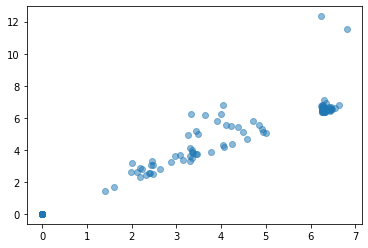

In [32]:
PD(X)

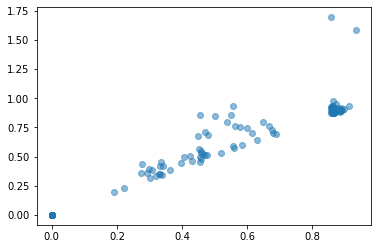

In [33]:
PD(scale(X))

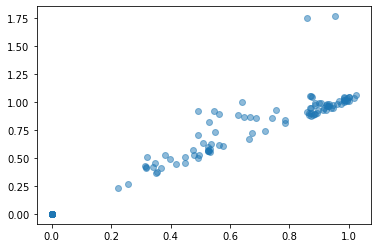

In [35]:
PD(normalize(X))

In [34]:
def normalize(X):
    return (X - tf.math.reduce_mean(X,axis=0))/tf.math.reduce_std(X,axis=0)

In [24]:
def scale(X):
    return (X - tf.math.reduce_mean(X,axis=0))/tf.math.reduce_max(tf.math.reduce_std(X,axis=0))

In [20]:
class CustomAccuracy_norm(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

                
        X = scale(X) #*(n_samples**(1/X.shape[1]))
        Y = scale(Y) #*(n_samples**(1/Y.shape[1]))
        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, X=X, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

In [3]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt


In [4]:
from sklearn.utils import check_random_state
import numpy               as np
import tensorflow_addons   as tfa
import tensorflow          as tf
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd
import keras.backend as K

from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


#import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

# import packages
import scipy
from scipy.stats import norm 
import time
import statsmodels.api as sm
import math
#from scipy.cluster.vq import whiten
from tensorflow.keras import initializers
from sklearn.metrics import accuracy_score, precision_score, recall_score
#from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model
from data_generation import *

In [89]:
def myDistance(X, Y, num_partitions):
    

    ## character point
    indX = np.argmax(X[:,1]-X[:,0])
    indY = np.argmax(Y[:,1]-Y[:,0])
    chaX = X[indX,:]
    chaY = Y[indY,:]
    
    ## define the searching interval
    B = 1e3 ## translation parameter. This is a bug in gudhi that they donot accept negative inputs
    oriDist = gd.bottleneck_distance(X+B,Y+B)
    print("original bottleneck distance", oriDist)
    upBound = max(Y[:,1])-chaX[1]+oriDist
    lowBound = chaY[1]-max(X[:,1])-oriDist
    
    ## define shifts
    shifts = np.linspace(lowBound, upBound, num_partitions)
    shiftInv = np.append(shifts, 0)
    bottleneckDistance = []
    
    ## compute bottleneck distance
    for scale in shiftInv:
        shiftX = scale+X
        dist = gd.bottleneck_distance(shiftX+B, Y+B)
        bottleneckDistance.append(dist)

    minBottleneckDistance = min(bottleneckDistance)
#     print("shifts",shiftInv)
    bestShift = shiftInv[np.array(bottleneckDistance).argmin()]
    bestShift = bestShift.item()

    print("dilation-invariant bottleneck distance (using log) is", minBottleneckDistance)
    
    return shiftInv, bottleneckDistance, minBottleneckDistance, bestShift



In [7]:
def make_swiss_roll_with_hole(n_samples=100, noise=0.0, random_state=None):
    # https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/datasets/_samples_generator.py#L1401
    generator = check_random_state(random_state)
    t = 1.5 * np.pi * (1 + 2 * generator.rand(1, n_samples))
    x = t * np.cos(t)
    y = 21 * generator.rand(1, n_samples)
    z = t * np.sin(t)

    X = np.concatenate((x, y, z))

    # ranges of three coordinates:
    # np.max(X[2,:]) = 14.136094274051034
    # np.min(X[2,:]) = -11.040707948365629
    # np.max(X[1,:]) = 20.996180119068676
    # np.min(X[1,:]) = 0.004955591716158225
    # np.max(X[0,:]) = 12.60593128332993
    # np.min(X[0,:]) = -9.47727415039662

    # mask = ((X[0, :]>-8) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    # mask = ((X[0, :]>-10) & (X[0, :]<0) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    mask = ((X[0, :]>-10) & (X[0, :]<-5) & (X[2, :]>-4) & (X[2, :]<7) & (X[1, :]>5) & (X[1, :]<15))
    X[:, mask] = None
    
    X += noise * generator.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)

    # remove the nan values (related to hole):
    hole_point_indices_3D = np.isnan(X)
    hole_point_indices = np.asarray([(hole_point_indices_3D[i, 0] | hole_point_indices_3D[i, 1] | hole_point_indices_3D[i, 2]) for i in range(hole_point_indices_3D.shape[0])])
    t = t[~hole_point_indices]
    X = X[~hole_point_indices]

    return X

In [26]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()
    

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    
    
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, X, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        self.X = X
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card
        X = self.X

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z=self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

In [88]:
class shift_inv_dist_zhaoyang(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        
        X = scale(X)
        Y = scale(Y)
        
        fig, ax = plt.subplots()
        
        #plots the 2d projection
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()
        
        modelR = RipsModel(P=Y, X=X, mel=12, dim=1, card = 150)
        
        

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        Y_pd = Zdgm #.numpy()      

        Xdgm = modelR.call()[0]
        X_pd = Xdgm #.numpy()

        
        #shifting the data so its >=0 so we can take the log 

        X_pd += 0.1 #tf.math.abs(tf.math.reduce_min(X_pd)) #ASK PROFS ABOUT THIS 0.1 shift okay?
        Y_pd += 0.1 #tf.math.abs(tf.math.reduce_min(Y_pd)) 

        X_pd = tf.math.log(X_pd) 
        Y_pd = tf.math.log(Y_pd)
        
        #check for issues with numpy vs tensorflow            
        shiftInv, bottleneckDistance, minBottleneckDistance, bestShift = myDistance(Y_pd, X_pd, 100)
        
        
        #best shift
        shiftedY = Y_pd + bestShift #1# + bestShift #fix this 
        
        D = X_pd.numpy()
        D1 = shiftedY.numpy()
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
#         line = max(max(D1[:,0]),max(D[:,0]))
#         plt.plot([0,line],[0,line])
        plt.show()


        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(shiftedY, X_pd, order=2, internal_p=2, enable_autodiff=True))
        
        #Loss is bottleneck distance
        #B = 1e3
        #loss = gd.bottleneck_distance(shiftedY, X_pd, enable_autodiff=True) #wants numpy arguments, maybe try later 
            

        return loss

In [63]:
class shift_inv_dist(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):
        
        #X is the original data dim3
        #Y is the projected data dim2 
      
        fig, ax = plt.subplots()
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()
        
        #X and Y are tensors
        #remember mel
        
        print("X before",X)
        print("Y before",Y)
        
        
        #This is in the wrong place --> do it on pd not on data
        X += tf.math.abs(tf.math.reduce_min(X)) #normalize(X) 
        Y += tf.math.abs(tf.math.reduce_min(Y)) #normalize(Y) 
        
        
        X = tf.math.log(X)
        Y = tf.math.log(Y)

#         X = X.numpy()
#         Y = Y.numpy() 
#         X += np.abs(np.min(X))
#         Y += np.abs(np.min(Y))
        
#         X = np.log(X)
#         Y = np.log(Y)
        
        
        st = gd.RipsComplex(points = X, 
                    max_edge_length = 12).create_simplex_tree(max_dimension=2)
        st.persistence() #computes persistence intervals

        #extract persistence intervals for specified dim
        pd_X = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32) #original data
        
        st = gd.RipsComplex(points = Y, 
                    max_edge_length = 12).create_simplex_tree(max_dimension=2)
        st.persistence() #computes persistence intervals

        #extract persistence intervals for specified dim
        pd_Y = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32) #original data
        
        #==================
        #Find best shift
        #==================
        
        #we want to shift the projected data
        
            
        shiftInv, bottleneckDistance, minBottleneckDistance, bestShift = myDistance(pd_Y, pd_X, 100)
        
        shiftedY = pd_Y + bestShift
#         st = gd.RipsComplex(points = shiftedY, 
#                     max_edge_length = 12).create_simplex_tree(max_dimension=2)
#         st.persistence() #computes persistence intervals
        
#                 #extract persistence intervals for specified dim
#         pd_Y_best = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32) #original data
        
        D = pd_X
        D1 = shiftedY
        
        print("shiftedY",shiftedY)
        
        plt.figure()   
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        #line = max(max(D1[:,0]),max(D[:,0]))
        #plt.plot([0,line],[0,line])
        plt.show()
        

        loss = minBottleneckDistance
        loss = tf.convert_to_tensor(loss)
        
        print(loss)

        return loss

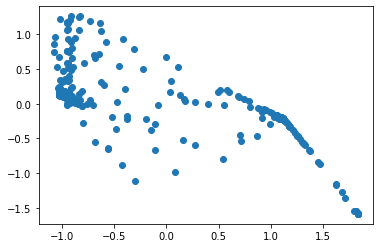

original bottleneck distance 0.314605712890625
dilation-invariant bottleneck distance (using log) is 0.228546142578125


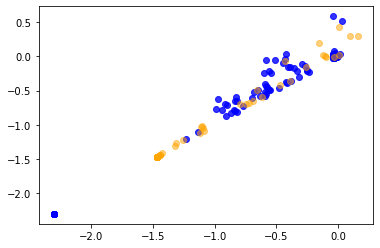

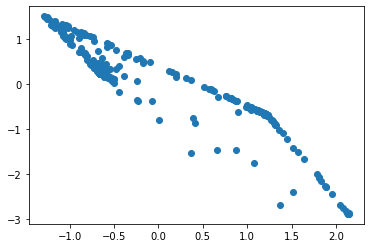

original bottleneck distance 0.314605712890625
dilation-invariant bottleneck distance (using log) is 0.25091552734375


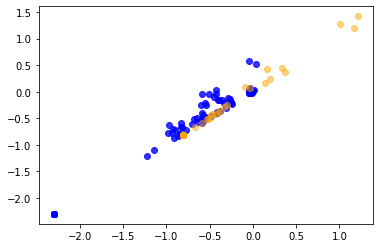

In [91]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
X = swiss

lr = 0.1
n_samples = 300
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=lr,
                decay_steps=100000,
                decay_rate=0.96,
                staircase=True)
activation = "sigmoid"
layer = 2
initializer = initializers.GlorotNormal(seed=1)

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(3, activation=activation,kernel_initializer=initializer),
        tf.keras.layers.Dense(2)
        ])

                
model.compile(loss=shift_inv_dist_zhaoyang(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_decay, name='Adam'),run_eagerly=True)
history = model.fit(X, X,epochs=2,batch_size=n_samples,verbose = 0) 

original bottleneck distance 6.385148351220664
dilation-invariant bottleneck distance (using log) is 3.251144030742807


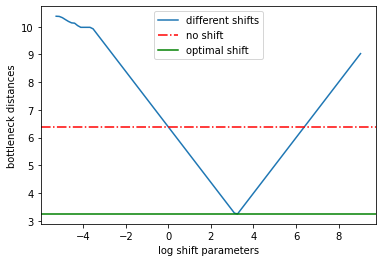

In [9]:
#load data

#file_list = ['activity_net_euclidean_cosine.npz','activity_net_euclidean.npz']
#file_list = ['activity_net_euclidean_expmap_poincare.npz','activity_net_poincare.npz']
file_list = ['mammals_euclidean_cosine.npz','mammals_euclidean.npz']
#file_list = ['mammals_euclidean_expmap_poincare.npz','mammals_poincare.npz']

dist_list = [np.load(u)['arr_0'] for u in file_list]

X = dist_list[0][0]
Y = dist_list[1][0]

X = np.delete(X, -1, axis = 1)
Y = np.delete(Y, -1, axis = 1)

# ## avoid -inf in log map
ep = 1e-10
X = np.log(X+ep)
Y = np.log(Y+ep)

shiftInv, bottleneckDistance, minBottleneckDistance, bestShift = myDistance(X, Y, 100)

plt.figure()
label = ['different shifts','no shift','optimal shift']
plt.xlabel("log shift parameters")
plt.ylabel("bottleneck distances")
plt.plot(shiftInv[0:len(shiftInv)-1], bottleneckDistance[0:len(bottleneckDistance)-1])
# the last element corresponds to no dilation
plt.axhline(y=bottleneckDistance[-1], color='r', linestyle='-.')
plt.axhline(y=minBottleneckDistance, color='g', linestyle='-')
plt.legend(label, loc='best')

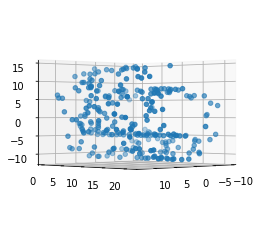

In [8]:
np.random.seed(1)
swiss = make_swiss_roll_with_hole(n_samples = 300)
swiss = np.array(swiss, dtype = np.float32)
plot(swiss)
#swiss += np.abs(swiss.min())


In [9]:
PD(swiss)

NameError: name 'RipsModel' is not defined

In [31]:
def PD(X,mel=30):
    X = np.array(X, dtype = np.float32) 
    modelR = RipsModel(P=X,X=X, mel=mel, dim=1, card = 150)
    Xdgm = modelR.call()[0]
    plt.scatter(Xdgm.numpy()[:,0],Xdgm.numpy()[:,1],alpha=0.5)
    return 

def plot(X,dim = 3,deg=45):
    
    if dim==3:
        fig = plt.figure(figsize=plt.figaspect(1))
        ax=fig.add_subplot(projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2])
        ax.view_init(0,deg)
        
    return 


In [43]:
#load data

#file_list = ['activity_net_euclidean_cosine.npz','activity_net_euclidean.npz']
#file_list = ['activity_net_euclidean_expmap_poincare.npz','activity_net_poincare.npz']
file_list = ['mammals_euclidean_cosine.npz','mammals_euclidean.npz']
#file_list = ['mammals_euclidean_expmap_poincare.npz','mammals_poincare.npz']

dist_list = [np.load(u)['arr_0'] for u in file_list]

X = dist_list[0][0]
Y = dist_list[1][0]

X = np.delete(X, -1, axis = 1)
Y = np.delete(Y, -1, axis = 1)

# ## avoid -inf in log map
ep = 1e-10
X = np.log(X+ep)
Y = np.log(Y+ep)